# **Attention - Tradutor Português para Inglês**

- Neste notebook vamos criar um algoritmo capaz de traduzir sentenças do Inglês para o Português.
- O código é o mesmo da tradução Inglês-Português, com poucas modificações pontuais.
- Sendo assim, apenas o código é mostrado. Para verificar a teoria, comentários e explicações do código, veja "Attention_rnn_1_translateEnglishToPortuguese_NLP_GColab.ipynb".

## O trecho no qual é mostrada a inversão do tradutor Inglês-Português para Português-Inglês é comentada e explicada abaixo.

In [ ]:
#Garantir que está usando a versão mais recente de Keras
! pip install keras --upgrade

# **Attention**

# **Many-to-One Task**


# **Montar o Google Drive localmente - Autorizar conexão do Google Colab aos arquivos do Google Drive**

O exemplo abaixo mostra como montar o Google Drive no seu ambiente de execução usando um código de autorização, além de como gravar e ler arquivos nele. Depois de executado, você verá o novo arquivo &#40;<code>foo.txt</code>&#41; no <a href="https://drive.google.com/">https://drive.google.com/</a>.

Isto permite somente ler, gravar e mover arquivos. Para modificar de maneira programática as configurações de compartilhamento ou outros metadados, use uma das opções abaixo.

<strong>Observação:</strong> ao usar o botão "Montar Drive" no navegador de arquivos, não é necessário usar nenhum código de autenticação para notebooks que tenham sido editados somente pelo usuário atual.

In [ ]:
#Esta célula é utilizada para conectar à conta do Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importar bibliotecas para análise**

In [ ]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

In [ ]:
# make sure we do softmax over the time axis
# expected shape is N x T x D
# note: the latest version of Keras allows you to pass in axis arg
def softmax_over_time(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s

# **Configurações das redes neurais e do processamento de texto**

In [ ]:
# config
BATCH_SIZE = 64
EPOCHS = 30
LATENT_DIM = 400
LATENT_DIM_DECODER = 400 # idea: make it different to ensure things all fit together properly!
NUM_SAMPLES = 4000 #20000 is too much for both AWS and Colab available RAMs
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

**`BATCH_SIZE`**: quantos dados são usados em cada forward and backward pass. Se temos 3200 dados e o batch size é 32, ocorrem 100 passagens de 32 dados em cada época.

# **Criação das listas que armazenarão as sentenças a serem traduzidas**

Como visto, no treinamento utilizamos a abordagem do Teacher Forcing:
- Temos as sequências (sentenças) de input a serem traduzidas. O início da sentença é assinalado pelo token `<SOS>`.
- As sentenças são armazenadas de forma consecutiva em uma lista, chamada `input_texts`. Assim, cada token `<SOS>` indica o apêndice de um novo elemento a esta lista.
- Para treinarmos o modelo de redes neurais, temos uma série de sentenças para as quais conhecemos a tradução correta (os targets). 
- Criamos, então, uma nova lista, chamada `target_texts`, que armazenará sequencialmente as sentenças traduzidas.
- Repare que as listas `input_texts` e `target_texts` possuem índices correspondentes: a tradução do elemento (sentença) de índice i de `input_texts`, `input_texts[i]`, é o elemento (sentença) de índice i de `target_texts`, `target_texts[i]`.
- A indexação das listas começa em zero. Assim, se a lista possui n elementos, seus índices i são tais que 0 ≤ i ≤ (n-1).

No teacher forcing, os inputs de uma unidade recorrente são: os estados h e c obtidos como saídas da unidade anterior; e os targets (sentenças traduzidas, com tradução validada).
- Assim, ainda que o algoritmo tenha traduzido alguma palavra de forma incorreta, ele utilizará a palavra correta para tentar prever a tradução da palavra seguinte. 
- Com esta correção, o treinamento não é prejudicado caso uma palavra tenha sido prevista de forma equivocada.
- Entretanto, o teacher forcing exige que haja um offset de uma unidade entre a palavra que a unidade irá prever e a palavra target utilizada como input.
- **De outra forma: o input de uma unidade será a palavra que a unidade anterior deveria ter previsto** (ainda que a previsão do algoritmo tenha sido equivocada).
- Sem este offset, ou seja, se a unidade recorrente fosse alimentada exatamente com a palavra target que ela deveria prever, ela seria ensinada a simplesmente copiar o seu input no seu output, algo sem utilidade.
- Assim, criamos a lista `target_texts_inputs` para armazenar as sequências de target com o offset de 1 unidade.

In [ ]:
# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

# **Inverter o tradutor Inglês-Português para o Português-Inglês**
- Basta fazer a troca: o que seria armazenado na lista de input (frases em inglês) será armazenado nas listas de target.
- O que seria armazenado nas listas de target (frases em português) será armazenado nas listas de input.

# **Para isso, basta trocar a ordem de armazenamento do resultante do split da linha:**

Em `input_text, translation, *rest = line.rstrip().split('\t')`

A primeira porção antes da quebra de linha é usada como input e a segunda como target e tradução. Como o dicionário é inglês/português, a primeira porção é em Inglês.

Sendo assim, mudamos esta linha para:

`translation, input_text, *rest = line.rstrip().split('\t')`

Para que o Inglês (primeira parte) se tornar a língua traduzida.

In [ ]:
#CARREGAR ARQUIVO COM O DICIONÁRIO
#Este arquivo contém frases traduzidas de um idioma para outro, e cuja tradução foi validada.
#Assim, este arquivo possui tanto inputs (frases a serem traduzidas) quanto os targets 
#(tradução que o algoritmo deve aprender)

# load in the data
# download the data at: http://www.manythings.org/anki/
t = 0
for line in open('portuguese_english_dict.txt'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # split up the input and translation
  #input_text, translation, *rest = line.rstrip().split('\t')
  #The line above makes the first part of the line prior to the break to be used as
  #input. Since this dictionary is English-Portuguese, it results into English to
  #Portuguese translation. To obtain the Portuguese to English, we must take the
  #first part as input. To do so, we simply invert the order of selection:
  
  translation, input_text, *rest = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 4000


# **Aplicar o método keras.tokenizer aos inputs para conversão das sentenças em números inteiros**

In [ ]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# **Associar cada palavra a uma linha (vetor de palavras) do word embedding**

In [ ]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 1872 unique input tokens.


# **Caracterização das sequências de texto obtidas e convertidas em inteiros**

In [ ]:
# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

# **Repetir as etapas anteriores para os outputs (tokenização, mapeamento e caracterização) para os outputs**

- O algoritmo para tradução lida com dois idiomas diferentes.
- Isto significa que temos 2 vocabulários distintos, um no Encoder (língua original), e outro no Decoder (idioma-alvo).

### **Como temos dois vocabulários, é necessário criar 2 tokenizers, um para cada idioma. O primeiro é aplicado às sentenças do idioma original, o segundo às do idioma target.**

- Isto também leva à necessidade de 2 mapeamentos word2idx distintos, cada um com suas próprias variáveis descritivas (total de palavras e máximo comprimento de sentença).

# **Tokenização**

In [ ]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# **Mapeamento (dicionário word2idx das saídas)**

In [ ]:
# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 1380 unique output tokens.


Este dicionário será responsável por converter os valores numéricos obtidos como saída do decoder em palavras, de modo a gerar as sentenças traduzidas.

# **Caracterização: número de palavras e máximo comprimento de sentença**

- Estas variáveis devem ser calculadas e armazenadas para uso posterior.

In [ ]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

In [ ]:
# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

# **Limitar comprimento das sequências de texto com o método pad_sequences**

# **Padding do Encoder**

In [ ]:
## pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_data.shape:", encoder_inputs.shape)
print("encoder_data[0]:", encoder_inputs[0])

encoder_data.shape: (4000, 8)
encoder_data[0]: [ 0  0  0  0  0  0  0 32]


# **Padding do Decoder**

In [ ]:
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_data[0]:", decoder_inputs[0])
print("decoder_data.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

decoder_data[0]: [ 2 60  0  0  0]
decoder_data.shape: (4000, 5)


Esta etapa é particularmente importante porque a biblioteca **Keras trabalha com sequências de dimensões constantes**.
- O formato do tensor de dados representa a dimensão da matriz (N x T) obtida. 
- Note que, como desejamos que o algoritmo aprenda a traduzir sentenças de diversos comprimentos, não limitamos a `MAX_SEQUENCE_LENGTH = 100` o máximo comprimento da sequência de textos, como em exemplos anteriores.
- N = contagem de elementos;
- T será o máximo comprimento permitido para o vetor de palavras (máximo possível de colunas).

# **Vamos criar um dicionário vazio, chamado word2vec** 
Este dicionário armazenará os dados já pré-configurados, i.e., palavras que já foram convertidas em vetores numéricos, e que estão disponíveis nas bases glove.6B.

- O comprimento dos vetores de palavras será o definido e armazenado em EMBEDDING_DIM.
- O dicionário possui como estrutura: a palavra como a chave (key); e o vetor de palavras (word vector) como o valor correspondente.
- A nomenclatura word2vec vem de "word pointing to vector".
- Os arquivos glove.6B consistem em txt contendo a cada linha uma palavra seguida dos valores das componentes dos vetores, separados por espaços em branco.
- Assim, nós: 1) carregamos uma linha; 2) dividimos (split) as linhas em tokens; 3) tomamos o primeiro token como sendo a palavra; 4) tomamos os demais tokens como o vetor; 5) convertemos o vetor em um NumPy array; 6) e, por fim, salvamos cada array no nosso dicionário.

In [ ]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


# **Pré-carregar a matriz de incorporação ("embedding matrix") que será utilizada pela rede neural**

In [ ]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)

Filling pre-trained embeddings...


# **Criação da matriz embedding**

In [ ]:
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

# **Criação de versão one-hot dos targets**

A função de "sparse cross-entropy" de Keras não funcionará se o input for uma sequência.
- Isto não era problema nos exemplos anteriores porque possuíamos apenas um target por input.
- Porém, agora **temos dois targets por input: cada amostra nos fornece uma sequência completa de targets**.

Como a "sparse cross-entropy" não foi projetada para este caso, é possível construir a própria função de perda.

Criação da matriz nula:

In [ ]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

Assinalar valores 1 aos elementos especificados:

In [ ]:
# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word > 0:
      decoder_targets_one_hot[i, t, word] = 1

Note que primeiro criamos uma matriz apenas com elementos nulos (np.zeros).
- A seguir, fornecemos o valor 1 apenas aos elementos especificados, de modo a diferenciá-los uns dos outros (ou seja, de modo a realizar o encoding destes elementos).

# **Construção e avaliação da RNN**

# **Criação da camada de embedding**

A criação da camada de embedding consiste em simplesmente criar um objeto do tipo "**Embedding**".

In [ ]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

# **Construção do restante do modelo de redes neurais recorrentes (RNNs)**

In [ ]:
##### build the model #####

# Set up the encoder - simple!
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(
  LATENT_DIM,
  return_sequences=True,
  # dropout=0.5 # dropout not available on gpu
))
encoder_outputs = encoder(x)

In [ ]:
# Set up the decoder - not so simple
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [ ]:
######### Attention #########
# Attention layers need to be global because
# they will be repeated Ty times at the decoder
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1) # to perform the weighted sum of alpha[t] * h[t]

In [ ]:
def one_step_attention(h, st_1):
  # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
  # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)
 
  # copy s(t-1) Tx times
  # now shape = (Tx, LATENT_DIM_DECODER)
  st_1 = attn_repeat_layer(st_1)

  # Concatenate all h(t)'s with s(t-1)
  # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
  x = attn_concat_layer([h, st_1])

  # Neural net first layer
  x = attn_dense1(x)

  # Neural net second layer with special softmax over time
  alphas = attn_dense2(x)

  # "Dot" the alphas and the h's
  # Remember a.dot(b) = sum over a[t] * b[t]
  context = attn_dot([alphas, h])

  return context

In [ ]:
# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

In [ ]:
# Unlike previous seq2seq, we cannot get the output
# all in one step
# Instead we need to do Ty steps
# And in each of those steps, we need to consider
# all Tx h's

# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

# collect outputs in a list at first
outputs = []

No caso do decoder, precisamos dos dois argumentos `return_sequences=True` e `return_state=True`, garantindo tanto o registro das saídas quanto dos estados a cada tempo.

Assim como visto para a geração de poemas, e**ste registro dos estados não é necessário para o treinamento, mas será para a realização de previsões. Nas previsões, utilizaremos o mesmo modelo de redes neurais com pesos já treinados, razão pela qual devemos definir estes parâmetros antecipadamente com o valor True**.

Como não é necessário armazenar os estados neste momento, podemos utilizar o sinal `_` em:

```
decoder_outputs, _, _ = decoder_lstm(
```
Com este sinal, não geramos o erro de exceção associado ao chamamento de menos variáveis à esquerda do que a quantidade de saídas à direita. Porém, as saídas à direita que seriam armazenadas pelo objeto substituído por `_` são apagadas da memória.
- Com isso, economizamos memória, já que não necessitamos armazenar estes estados durante o treinamento.

In [ ]:
for t in range(max_len_target): # Ty times
  # get the context using attention
  context = one_step_attention(encoder_outputs, s)

  # we need a different layer for each time step
  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(decoder_inputs_x)
  
  # combine 
  decoder_lstm_input = context_last_word_concat_layer([context, xt])

  # pass the combined [context, last word] into the LSTM
  # along with [s, c]
  # get the new [s, c] and output
  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

  # final dense layer to get next word prediction
  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)

# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D

In [ ]:
def stack_and_transpose(x):
  # x is a list of length T, each element is a batch_size x output_vocab_size tensor
  x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
  x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
  
  return x

In [ ]:
# make it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

# **Criação de um objeto do modelo ("model object")**

Agora que concluímos a construção do modelo, podemos assinalar ele a um objeto que armazenará as suas principais informações.

- **A função construtora ("constructor") deste objeto utiliza como primeiro argumento o input, e a saída ("output") como segundo argumento**.

In [ ]:
# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s, 
    initial_c,
  ],
  outputs=outputs
)

Note que o objeto que armazena o modelo foi denominado "model".

# **Função de perda e métrica de precisão**

Como visto, podemos definir funções de perda e de precisão adaptadas para o caso particular, como feito a seguir.
- Uma vez definidas estas funções, elas podem ser evocadas normalmente pelo processo de treinamento.



In [ ]:
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)

In [ ]:
def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

In [ ]:
# compile the model
model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# train the model
z = np.zeros((len(encoder_inputs), LATENT_DIM_DECODER)) # initial [s, c]

# **Treinar o modelo**

- Utilizamos o método **.fit** para treinar o modelo.
- **O modelo treinado ficará armazenado no objeto r** definido a seguir.

No trecho a seguir, o modelo é representado por `model`. 
- `r` representa um dicionário contendo diversas informações históricas a respeito do processo de treinamento do modelo.

In [ ]:
r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2
)

Epoch 1/30
50/50 [==============================] - 28s 354ms/step - loss: 5.0084 - acc: 0.3262 - val_loss: 4.9681 - val_acc: 0.3303
Epoch 2/30
50/50 [==============================] - 15s 293ms/step - loss: 3.9750 - acc: 0.3591 - val_loss: 4.7805 - val_acc: 0.3441
Epoch 3/30
50/50 [==============================] - 16s 315ms/step - loss: 3.6410 - acc: 0.4002 - val_loss: 4.8136 - val_acc: 0.3448
Epoch 4/30
50/50 [==============================] - 15s 302ms/step - loss: 3.3317 - acc: 0.4284 - val_loss: 4.6727 - val_acc: 0.3715
Epoch 5/30
50/50 [==============================] - 15s 293ms/step - loss: 3.0494 - acc: 0.4588 - val_loss: 4.5166 - val_acc: 0.3904
Epoch 6/30
50/50 [==============================] - 15s 292ms/step - loss: 2.7851 - acc: 0.4906 - val_loss: 4.5522 - val_acc: 0.4064
Epoch 7/30
50/50 [==============================] - 15s 305ms/step - loss: 2.5476 - acc: 0.5129 - val_loss: 4.5665 - val_acc: 0.4309
Epoch 8/30
50/50 [==============================] - 15s 303ms/step - 

# **Salvar modelo treinado no Google Drive para re-importá-lo futuramente (ou baixá-lo no ambiente offline)**

Aqui, forneça o mesmo endereço da pasta na qual os arquivos das bases de dados foram salvos. Assim, o modelo ficará salvo na mesma pasta, facilitando sua localização.

In [ ]:
folder_adress = "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 6 - Attention/"

In [ ]:
from keras.models import load_model
#Definicao do endereço e nome do novo arquivo:

file_address = folder_adress + "rnn1_attention_obtained_model.h5"
#file_address armazena o local em que sera salvo o modelo: o endereço da pasta foi concatenado
#ao nome e extensão desejados para o arquivo.
#note que o arquivo gerado se chama obtained_model.h5
#Em Keras, os modelos devem ser salvos com a extensão h5.

#Salvar modelo
model.save("attention_model_PortugueseToEnglish.h5")


#Modelos Scikit-learn: use o modelo da biblioteca dill:
#import dill
#dill.dump(model, open(file_address, 'wb'))
#Nosso modelo foi gerado com a denominação "model", como vimos acima.
#aqui, modifique "model" pelo nome do modelo declarado, caso seja outro o nome utilizado
#note que o arquivo gerado se chama obtained_model.dill
#o dill permite salvar em qualquer extensao (pkl, sav, pmml, ...)

# **Reimportar modelo pré-treinado**

Para reimportar o modelo, basta seguir o código abaixo (ajuste-o de acordo com a pasta do drive na qual está salvo o modelo obtido anteriormente) - basta substituir o valor de "file_address" pelo endereço correto

In [ ]:
from keras.models import load_model
file_address = "/content/drive/MyDrive/Coisas úteis separadas para a Paula/Deep Learning - Advanced NLP and RNNs/Lesson 6 - Attention/rnn1_attention_obtained_model.h5"

model = load_model(file_address)


#Em Sckit-learn
#import dill
#loaded_model = dill.load(open(file_address, 'rb'))
#Agora o modelo carregado  recebe o nome de loaded_model
#todos os campos que recebiam o nome do modelo devem ter o nome substituído para loaded_model
#você também pode modificar o nome loaded_model para um nome de seu interesse. Por exemplo:
#model = dill.load(open(file_address, 'rb')) fará o modelo ser carregado com o nome model

#ATENÇÃO: Caso já haja um modelo 1 com o nome escolhido para carregar este modelo 2, o modelo 1 deixará de existir, 
#sendo substituído pelo modelo 2 carregado.

# **Plotar gráfico da função de perda**

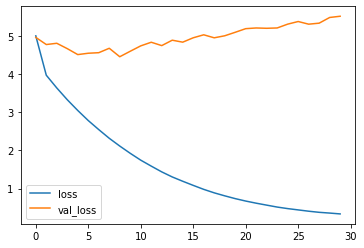

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

O descolamento das curvas indica certo grau de overfitting do modelo.
- Isto pode ter sido causado por um número reduzido de dados de treinamento, já que limitamos as amostras pela definição do hiperparâmetro `NUM_SAMPLES = 10000`.

# **Plotar gráfico da precisão**

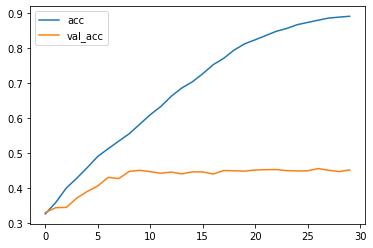

In [ ]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# **Construção do segundo modelo para o decoder**

Em Keras, precisamos especificar também os comprimentos das sequências ou séries temporais.
- Para o treinamento, o tamanho do input será simplesmente o comprimento da sequência mais longa a ser processada.
  - No treinamento (sistema encoder), nós alimentamos a rede com a sequência de input (frase) completa, e obtemos uma previsão para a palavra seguinte - tudo isto ocorre simultaneamente.
- Para os testes e previsões (sistema decoder), o tamanho do input é diferente. Nós só podemos passar uma palavra por vez, pois precisamos usar cada previsão como input da unidade recursiva seguinte.
  - Precisamos, então, construir um novo modelo, com novas entradas e novos tamanhos.


In [ ]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
# i.e. h(1), ..., h(Tx)
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# **Saída do modelo**

In [ ]:
# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

# note: we don't really need the final stack and tranpose
# because there's only 1 output
# it is already of size N x D
# no need to make it 1 x N x D --> N x 1 x D

In [ ]:
# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)

O modelo de redes neurais retornará apenas valores numéricos, os quais correpondem aos índices das palavras. 
- Precisamos, portanto, criar um mapeamento índice-palavras (i.e., informar a quais palavras correspondem cada um dos índices retornados).
- Isto permitirá que o modelo retorne sequências contendo palavras (sentenças).

### **O dicionário `idx2word_trans`, portanto, correlaciona os índices numéricos a cada uma das possíveis palavras de saída traduzidas (translated)**.

Assim, após as redes neurais retornarem um valor numérico, o algoritmo acessará este dicionário para coletar a palavra seguinte da sentença gerada.

In [ ]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

# **Função `decode_sequence`**

Esta função gerará a sentença traduzida, dada uma sentença de input.

In [ ]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))
  
  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']


  # [s, c] will be updated in each loop iteration
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))


  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        

    # Get next word
    idx = np.argmax(o.flatten())

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

  return ' '.join(output_sentence)

### **Uma diferença importante em relação ao language modelling é que aqui nós tomamos o máximo de probabilidade, ao invés de tomar um valor da distribuição estatística das frases possíveis**.
- Isso porque desejamos a tradução mais precisa possível, não um novo poema.

In [ ]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', input_texts[i])
  print('Predicted translation:', translation)
  print('Actual translation:', target_texts[i])

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input sentence: Eu vim sozinho.
Predicted translation: i am win.
Actual translation: I came alone. <eos>


Continue? [Y/n] y


-
Input sentence: Coma devagar.
Predicted translation: eat slowly.
Actual translation: Eat slowly. <eos>


Continue? [Y/n] y


-
Input sentence: Vocês têm 18 anos?
Predicted translation: are you 18?
Actual translation: Are you 18? <eos>


Continue? [Y/n] y


-
Input sentence: Nós entraremos.
Predicted translation: we agree.
Actual translation: We'll go in. <eos>


Continue? [Y/n] y


-
Input sentence: Tom acenou com a cabeça.
Predicted translation: tom nodded.
Actual translation: Tom nodded. <eos>


Continue? [Y/n] y


-
Input sentence: Que fome!
Predicted translation: i i hungry!
Actual translation: Am I hungry! <eos>


Continue? [Y/n] y


-
Input sentence: Ignore-as.
Predicted translation: ignore them.
Actual translation: Ignore them. <eos>


Continue? [Y/n] y


-
Input sentence: Te cuida!
Predicted translation: take care!
Actual translation: Take care! <eos>


Continue? [Y/n] y


-
Input sentence: Tom bebe.
Predicted translation: tom drinks. tom.
Actual translation: Tom drinks. <eos>


Continue? [Y/n] y


-
Input sentence: Eu estou feliz.
Predicted translation: i am happy.
Actual translation: I am happy. <eos>


Continue? [Y/n] y


-
Input sentence: Ela bateu nele.
Predicted translation: she hit him.
Actual translation: She hit him. <eos>


Continue? [Y/n] y


-
Input sentence: É seu?
Predicted translation: is it yours?
Actual translation: Is it yours? <eos>


Continue? [Y/n] y


-
Input sentence: Tom bebe.
Predicted translation: tom drinks. tom.
Actual translation: Tom drinks. <eos>


Continue? [Y/n] n


# **NOTA: Realizar previsões com o modelo**

Note que o comando `model.predict(X)` calcula os valores previstos pelo modelo `model` para cada um dos valores do dataframe `X` fornecido como input.